In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re 
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv('amazon_alexa.tsv', sep = '\t')
df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


# Data cleaning & EDA

In [3]:
df['feedback'].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

In [3]:
def makeLower(text):
    return text.lower()

In [4]:
def removePunct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [5]:
df['verified_reviews'] = df['verified_reviews'].apply(makeLower)
df['verified_reviews'] = df['verified_reviews'].apply(removePunct)
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,love my echo,1
1,5,31-Jul-18,Charcoal Fabric,loved it,1
2,4,31-Jul-18,Walnut Finish,sometimes while playing a game you can answer ...,1
3,5,31-Jul-18,Charcoal Fabric,i have had a lot of fun with this thing my 4 y...,1
4,5,31-Jul-18,Charcoal Fabric,music,1


In [6]:
stopwords = stopwords.words('english')
stopwords.append('and')

In [7]:
def clean(text):
    words = text.split()
    new_words = []
    
    for w in words:
        if w not in stopwords and w.isalpha():
            new_words.append(w)
    
    new_sent = ' '.join(new_words)
    return new_sent

In [8]:
df['verified_reviews'] = df['verified_reviews'].apply(clean)
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,love echo,1
1,5,31-Jul-18,Charcoal Fabric,loved,1
2,4,31-Jul-18,Walnut Finish,sometimes playing game answer question correct...,1
3,5,31-Jul-18,Charcoal Fabric,lot fun thing yr old learns dinosaurs control ...,1
4,5,31-Jul-18,Charcoal Fabric,music,1


C:\Users\Sahil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='feedback', ylabel='count'>

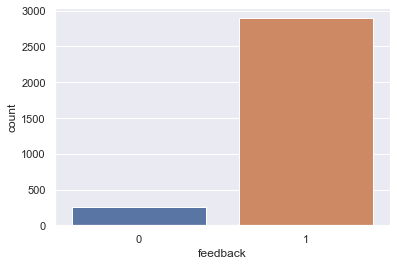

In [11]:
sns.countplot(df['feedback'])

In [14]:
def wordCloud(dataframe, feedback):
    words = df[df['feedback'] == feedback]['verified_reviews'].tolist()
    combined_words = ' '.join(words)
    plt.figure(figsize = (15, 15))
    plt.imshow(WordCloud(background_color = 'white').generate(combined_words))
    plt.axis('off')
    plt.show()

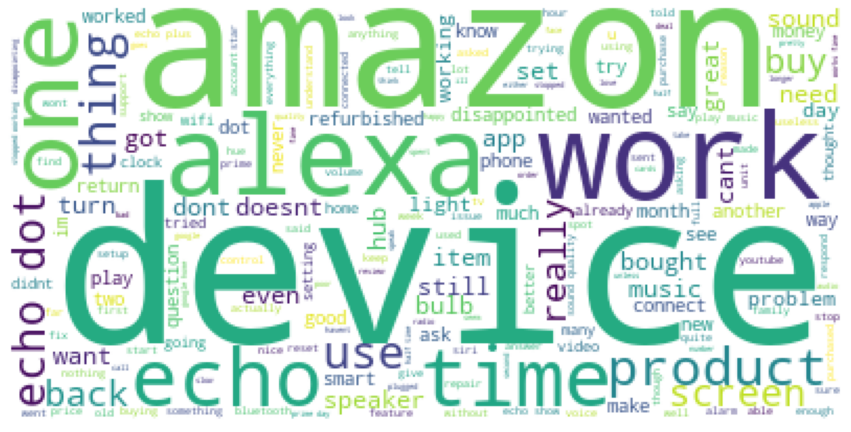

In [15]:
wordCloud(df, 0)

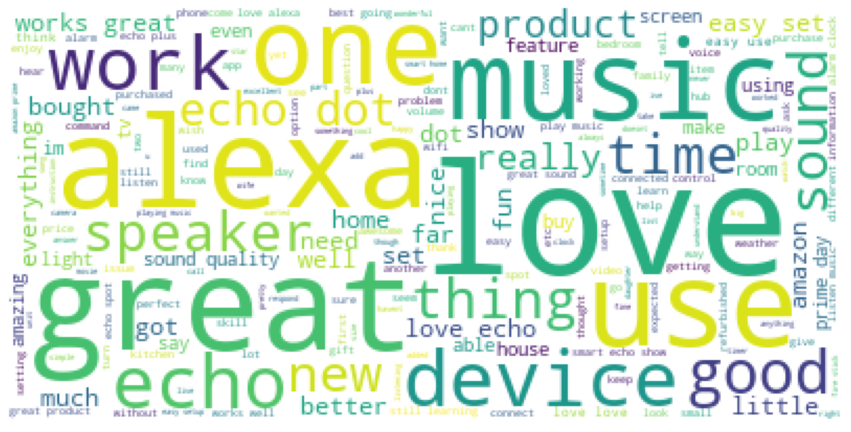

In [16]:
wordCloud(df, 1)

# Data preprocessing

In [9]:
X = df['verified_reviews']
Y = df['feedback']

In [10]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, stratify = Y, test_size = 0.25, random_state = 40)
len(Xtrain), len(Xtest)

(2362, 788)

In [11]:
tokenizer = Tokenizer(num_words = 1000, oov_token = '<OOV>')
tokenizer.fit_on_texts(Xtrain)

In [12]:
word_index = tokenizer.word_index
len(word_index)

3617

In [13]:
max_length = max([len(sent.split(' ')) for sent in Xtrain])
max_length

238

In [14]:
train_sequences = tokenizer.texts_to_sequences(Xtrain)
train_padded_sequences = pad_sequences(train_sequences, maxlen = max_length, padding = 'post')

In [15]:
test_sequences = tokenizer.texts_to_sequences(Xtest)
test_padded_sequences = pad_sequences(test_sequences, maxlen = max_length, padding = 'post')

# Model building

In [16]:
model = keras.Sequential([
    layers.Embedding(input_dim = len(word_index) + 1, output_dim = 64, input_length = max_length),
    
    layers.Bidirectional(layer = layers.LSTM(units = 32)),
    
    layers.Dense(units = 64, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(units = 64, activation = 'relu'),
    layers.Dropout(0.5),
    
    layers.Dense(units = 1, activation = 'sigmoid')
    
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 238, 64)           231552    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
hist = model.fit(train_padded_sequences, Ytrain, batch_size = 32, epochs = 10,
                 validation_data = (test_padded_sequences, Ytest))

Epoch 1/10
74/74 [==============================] - 29s 155ms/step - loss: 0.3855 - accuracy: 0.9018 - val_loss: 0.2693 - val_accuracy: 0.9188
Epoch 2/10
74/74 [==============================] - 12s 162ms/step - loss: 0.2583 - accuracy: 0.9183 - val_loss: 0.2207 - val_accuracy: 0.9188
Epoch 3/10
74/74 [==============================] - 12s 164ms/step - loss: 0.1769 - accuracy: 0.9293 - val_loss: 0.1932 - val_accuracy: 0.9150
Epoch 4/10
74/74 [==============================] - 12s 162ms/step - loss: 0.1070 - accuracy: 0.9606 - val_loss: 0.2352 - val_accuracy: 0.9112
Epoch 5/10
74/74 [==============================] - 15s 204ms/step - loss: 0.0772 - accuracy: 0.9742 - val_loss: 0.3064 - val_accuracy: 0.9340
Epoch 6/10
74/74 [==============================] - 13s 178ms/step - loss: 0.0646 - accuracy: 0.9801 - val_loss: 0.2816 - val_accuracy: 0.9251
Epoch 7/10
74/74 [==============================] - 14s 186ms/step - loss: 0.0483 - accuracy: 0.9835 - val_loss: 0.3164 - val_accuracy: 0.9277

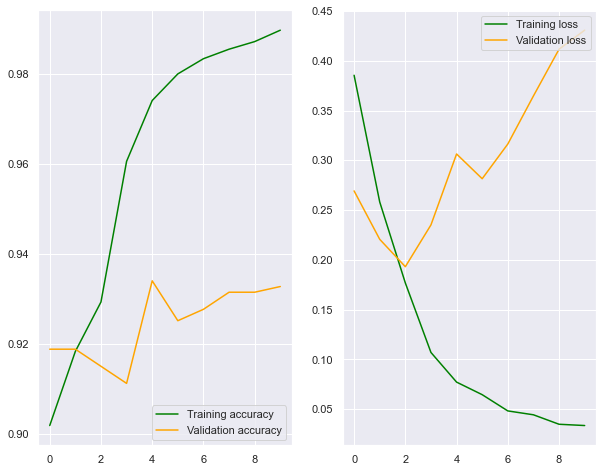

In [19]:
plt.figure(figsize = (10, 8))


plt.subplot(1,2,1)
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(10)
plt.plot(epochs, train_acc, label = 'Training accuracy', color = 'green')
plt.plot(epochs, val_acc, label = 'Validation accuracy', color = 'orange')
plt.legend(loc = 'lower right')


plt.subplot(1,2,2)
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(10)
plt.plot(epochs, train_loss, label = 'Training loss', color = 'green')
plt.plot(epochs, val_loss, label = 'Validation loss', color = 'orange')
plt.legend(loc = 'upper right')
plt.show()

# Predictions

In [20]:
Ypred = model.predict(test_padded_sequences)

25/25 [==============================] - 2s 32ms/step


In [22]:
Ypred = np.round(Ypred)

In [23]:
print(classification_report(Ytest, Ypred))

              precision    recall  f1-score   support

           0       0.64      0.39      0.49        64
           1       0.95      0.98      0.96       724

    accuracy                           0.93       788
   macro avg       0.79      0.69      0.72       788
weighted avg       0.92      0.93      0.93       788



<AxesSubplot:>

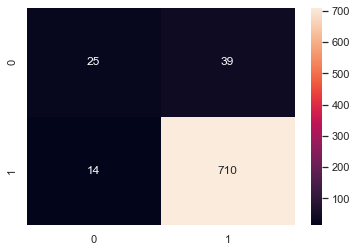

In [25]:
cm = confusion_matrix(Ytest, Ypred)
sns.heatmap(cm, annot = True, fmt = 'd')

Because of the imbalance of the classes, we get very less f1-score for class 0.